# Extracting Instagram Network

##### Imports

In [112]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import importlib
import time
import json
import os
import shutil

import insta_graph.insta_scrape as insta_scrape
import insta_graph.utils.ig_network_tools as ig_network_tools

from constants import RAW_FOLLOWING_PATH, RAW_EXTRACTED_FOLLOWING_PATH, PROCESSING_FOLLOWING_PATH, PROCESSED_FOLLOWING_PATH

### Getting Instagram-provided 'following' list
The first step to extracting your Instagram network is requesting your data from Instagram. [here](https://help.instagram.com/181231772500920). According to Instagram, it can take up to 30 days to receive the download link. Once you've received the link, locate `following.json` in `followers_and_following` and move the file to `data/raw`. Then, the following code block will create a new copy in the correct format for loading:

In [40]:
insta_scrape.transform_ig_provided_following_list(RAW_FOLLOWING_PATH, RAW_EXTRACTED_FOLLOWING_PATH)

The file '../data/raw/following_data.json' already exists.


### Initial Round of Follower Loading
The following code Selenium to scrape the mutual Instagram followers from a list of people you are following. Ensure that you review and understand Instagram's terms of service before executing this code. Here are some notes to consider if you want to extract the connections between your network:
 - I'm following around 1,350 people, and extracting all of the connections between them was an iterative process over the course of about a week.
  - From what I can see, Instagram stops populating the `MutualFirst` modal (www.instagram.com/username/followers/mutualOnly) after around 100 profiles, and will stop loading in profiles at that point. If that happens, close the webbrowser and try again in an hour or so.
  - There is a maximum profile views per day of around a couple hundred, and at this point Instagram will stop loading profiles entirely

Set up driver and navigate to Instagram

In [89]:
options = Options()
options.add_experimental_option("detach", True)
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

driver.get("https://www.instagram.com/")
driver.maximize_window()

time.sleep(2)

*Note: You will need to manually log into Instagram on your driver before proceeding*

In [43]:
with open(RAW_EXTRACTED_FOLLOWING_PATH, 'r') as f:
    following_data = json.load(f)

In [47]:
# Determining first username to be populated (because Instagram won't let us do it all at once)
last_follower_loaded = insta_scrape.last_populated_following(following_data)
last_follower_loaded

'Load complete'

*Note: For Instagram to load in new data, the web browser must remain visible.*
If Instagram stops loading in new data, terminate the script and try again in an hour or two

In [48]:
if last_follower_loaded != 'Load complete':
    insta_scrape.load_all_mutual_followers(driver, json_path=RAW_EXTRACTED_FOLLOWING_PATH, start_element=last_follower_loaded)

# Graph Extraction Quality Checks

Create a new file for following data we're processing further

In [64]:
if (last_follower_loaded == 'Load complete') and not os.path.exists(PROCESSING_FOLLOWING_PATH):
    shutil.copyfile(RAW_EXTRACTED_FOLLOWING_PATH, PROCESSING_FOLLOWING_PATH)

Check if Instagram listed someone we follow as `Follow` instead of `Following`, meaning we likely cut our scraping process too soon for that name

In [84]:
with open(PROCESSING_FOLLOWING_PATH, 'r') as f:
    following_data = json.load(f)

suspect_usernames = []
following = [user['username'] for user in following_data]
for user in following_data:
    if user['mutual_followers'] != ['Load Issue']:
        for follower in user['mutual_followers']:
            if (follower['username'] in following) and (follower['follow_status'] == 'Follow'):
                suspect_usernames.append(user['username'])

list(set(suspect_usernames))

[]

In [85]:
insta_scrape.update_mutual_followers_for_users(driver,
                                               json_filepath=PROCESSING_FOLLOWING_PATH,
                                               user_list=suspect_usernames,
                                               output_filepath=PROCESSING_FOLLOWING_PATH)

0it [00:00, ?it/s]


In [86]:
user_metrics = pd.DataFrame({
    'username': [user['username'] for user in following_data]
})

user_metrics['n_followers'] = user_metrics['username'].apply(lambda x: len(ig_network_tools.get_mutual_followers(x, following_data))+1)
user_metrics['n_following'] = user_metrics['username'].apply(lambda x: len(ig_network_tools.get_mutual_following(x, following_data))+1)
user_metrics['follower_following_discrepancy'] = user_metrics['n_followers'] - user_metrics['n_following']
user_metrics['reciprocity'] = user_metrics['n_following'] / user_metrics['n_followers']

Text(0.5, 1.0, 'Histogram of Follower - Following Discrepancies')

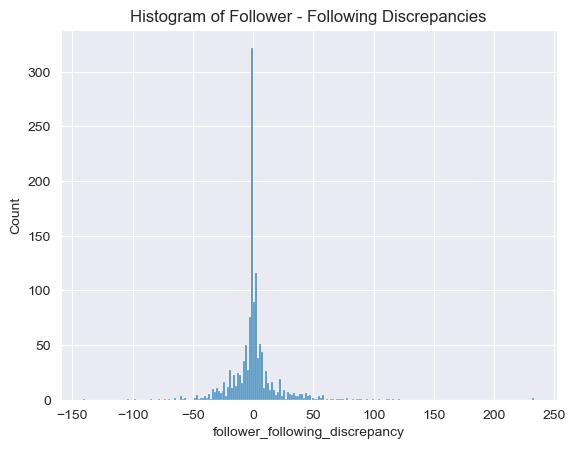

In [87]:
sns.histplot(data=user_metrics, x='follower_following_discrepancy')
plt.title('Histogram of Follower - Following Discrepancies')

As of my first pass there are a lot of users with very high reciprocity, meaning we didn't really scrape many of their actual followers

In [ ]:
user_metrics.sort_values('reciprocity', ascending=False)

We'll scrape users with the highest reciprocity for a second pass

In [83]:
second_pass = user_metrics.sort_values('follower_following_discrepancy', ascending=True).head(50)['username'].tolist()
insta_scrape.update_mutual_followers_for_users(driver,
                                               json_filepath=PROCESSING_FOLLOWING_PATH,
                                               user_list=second_pass,
                                               output_filepath=PROCESSING_FOLLOWING_PATH)

 81%|████████  | 81/100 [37:21<08:45, 27.68s/it]


MaxRetryError: HTTPConnectionPool(host='localhost', port=63600): Max retries exceeded with url: /session/58632d24d84eb469fd5124dc06c84f2f/source (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x14aaeb430>: Failed to establish a new connection: [Errno 61] Connection refused'))

Users with low reciprocity are either:
1. Organizations / Influencers
2. Narcissists (that aren't influencers)
3. People that Instagram didn't load for me. It's totally possible that there are people that Instagram didn't load in other people's mutual follower windows since the lists that they've provided haven't proven to be reliable. The good news is, there aren't too many of these people, and as long as we've scraped their mutual followers successfully we should have a comprehensive list of their connections

In [ ]:
user_metrics.sort_values('reciprocity', ascending=True)

There are a few organizational accounts that I can pick out of this, but for most of these I think the problem is that Instagram for whatever reason didn't load these people in the mutual follower modal of others, which is why they are so low. When I was watching the Selenium loading process, a lot of times the mutual followers weren't all loaded first, so there could very well be some system issues on Instagram's end that account for this. To simplify things, we're going to assume bidirectional relationships. Since we're going to remove organizations and creators, we can assume that of the people remaining, if someone we know follows another person we know chances are they probably both know each other.

You can identify organizational / creator accounts on the Instagram app on your phone by going to Profile->'Following'->'Hashtags, creators, and businesses'. These were the organizations / creators who I didn't know in person that I should remove:

In [107]:
false_users = [
    "designergirl",
    "someband",
    "artsy",
    "umadrid",
    "alumna",
    "prez",
    "globetrottersgive",
    "collegememepage",
    "uniaccount",
    "hssport",
    "hspirit",
    "sthsedu"
]

In [108]:
filtered_users = ig_network_tools.remove_users(false_users, following_data)

Save the filtered dataset

In [110]:
if not os.path.exists(PROCESSED_FOLLOWING_PATH):
    with open(PROCESSED_FOLLOWING_PATH, 'w') as file:
        json.dump(filtered_users, file, indent=4)
else:
    print("There's already a file here. Rename, move, or delete the file before proceeding")

There's already a file here. Rename, move, or delete the file before proceeding
